In [0]:
#################### Super Resolution of Sentinel Images using Cartosat Images ######################################### 

#### below code  to increase more ram for colab

In [0]:
d=[]
while(1):
  d.append('1')

In [1]:
# Importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import cv2

from skimage.io import imsave

import tensorflow
from tensorflow.keras.layers import Input, Dense , Add , Lambda
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
path = '/content/drive/My Drive/Super_Resolution/SRGAN/'
glob.glob( os.path.join(path,'Train_Images','*.jpg'))

['/content/drive/My Drive/Super_Resolution/SRGAN/Train_Images/sentinel1000.jpg',
 '/content/drive/My Drive/Super_Resolution/SRGAN/Train_Images/cartosat.jpg']

In [0]:
# Loading the training images and preprocessing Step

def splitImg(image,dim):
    ''' Takes input image and splits it into multiple images of dimension dim
    Outputs an array consisting of smaller images in order '''

    X=image.shape[0]/dim[0]
    Y=image.shape[1]/dim[1]
    no_images=X*Y
    #print("No. of images:",no_images)
    #print("Shape of image:",image.shape)
    images=[]
    i=0;j=0
    count=0
    while i <image.shape[0]:
        j=0
        while j<image.shape[1]:
            img=image[i:i+dim[0],j:j+dim[1],:]
            images.append(img)
            #count=count+1
            #print("Count: ",count)
            j=j+dim[1]
        i=i+dim[0]    
    return(np.array(images) , no_images)


def dataPreProcessing(dimHR,dimLR):
  ''' Takes dim as input which is the dimension of required training images to be obtained from the satellite image
      Outputs two arrays of high_resolution and low_resloution images
  '''
  # path='/content/drive/My Drive/Super_Resolution/SRGAN/'
  path = '/content/drive/My Drive/Super_Resolution/SRGAN/'

  images = glob.glob( os.path.join(path,'Train_Images', '*.jpg'))

  low_resolution_image=cv2.imread(path+'Train_Images/sentinel1000.jpg')
  high_resolution_image=cv2.imread(path+'Train_Images/cartosat.jpg')

  print('Dimension of HR Cartosat Image: ',high_resolution_image.shape)
  print('Dimension of LR Sentinel Image: ',low_resolution_image.shape)

  train_hr , no_images = splitImg(high_resolution_image,dimHR)
  train_lr , no_images= splitImg(low_resolution_image,dimLR)

  print("Total No. of Images: ",int(no_images))

  train_hr=train_hr.astype('float64')
  train_lr=train_lr.astype('float64')

  return(train_hr , train_lr , int(no_images))

In [0]:
# Function to randomly sample images from trainig set

def sampleImages(batch_size,train_hr,train_lr,no_images):
  # Generates a random batch of size batch_size 
 
 
  random_batch = np.random.choice(no_images, batch_size , replace=False)

  high_resolution_images = np.array([train_hr[i] for i in random_batch])
  low_resolution_images = np.array([train_lr[i] for i in random_batch])

  return(high_resolution_images , low_resolution_images)

In [0]:
def stichImages(images,dim):
  '''Takes images array and dimension to output image as input
  Outputs a stiched image of dimension dim '''


  out=np.zeros((dim[0],dim[1],3))
  X=images[0].shape[0];Y=images[0].shape[1]
    
  (i,j,k)=(0,0,0)
  while i < dim[0]:
      j=0
      while j < dim[1]:
          out[i:i+X,j:j+Y,:] = images[k]
          k=k+1
          j=j+Y
      i=i+X
  return(out)

In [0]:
def save_images(low_resolution_image, original_image, generated_image,path):
    """
    Save low-resolution, high-resolution(original) and
    generated high-resolution images in a single image
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("LR")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title("Original HR")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_image)
    ax.axis("off")
    ax.set_title("Generated SR")

    plt.savefig(path)

In [0]:
def residual_block(x):
  """
  Residual block
  """
  
  filters = [64, 64]
  kernel_size = 3
  strides = 1
  padding = "same"
  momentum = 0.8
  activation = "relu"

  res = Conv2D(filters=filters[0], kernel_size=kernel_size,
  strides=strides, padding=padding)(x)
  res = Activation(activation=activation)(res)
  res = BatchNormalization(momentum=momentum)(res)
  res = Conv2D(filters=filters[1], kernel_size=kernel_size,
  strides=strides, padding=padding)(res)
  res = BatchNormalization(momentum=momentum)(res)

  # Add res and x
  res = Add()([res, x])
  
  return res

In [0]:

def upsample(x, scale, num_filters):
  def upsample_1(x, factor, **kwargs):
      """Sub-pixel convolution."""
      x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
      return Lambda(pixel_shuffle(scale=factor))(x)

  if scale == 2:
      x = upsample_1(x, 2, name='conv2d_1_scale_2')
  elif scale == 3:
      x = upsample_1(x, 3, name='conv2d_1_scale_3')
  elif scale == 4:
      x = upsample_1(x, 2, name='conv2d_1_scale_2')
      x = upsample_1(x, 2, name='conv2d_2_scale_2')

def pixel_shuffle(scale):
  return lambda x: tensorflow.nn.depth_to_space(x, scale)

def build_generator():
  """
  Create a generator network using the hyperparameter values defined below
  :return:
  """
  residual_blocks = 16
  momentum = 0.8
  input_shape = (100, 100, 3)

  # Input Layer of the generator network
  input_layer = Input(shape=input_shape)

  # Add the pre-residual block
  gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)

  # Add 16 residual blocks
  res = residual_block(gen1)
  for i in range(residual_blocks - 1):
      res = residual_block(res)

  # Add the post-residual block
  gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
  gen2 = BatchNormalization(momentum=momentum)(gen2)

  # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
  gen3 = Add()([gen2, gen1])

  # Add an upsampling block
  gen4=Conv2D(64 * (2 ** 2), 3, padding='same')(gen3)
  gen4 = tensorflow.nn.depth_to_space(gen4, 2)
  #gen4 = upsample(gen3, scale = 2, num_filters = 64)
  gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
  gen4 = Activation('relu')(gen4)

  # Output convolution layer
  gen5 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen4)
  output = Activation('tanh')(gen5)

  # Keras model
  model = Model(inputs=[input_layer], outputs=[output], name='generator')
  return model

In [0]:
def build_discriminator():
    """
    Create a discriminator network using the hyperparameter values defined below
    :return:
    """
    leakyrelu_alpha = 0.2
    momentum = 0.8
    input_shape = (200, 200, 3)

    input_layer = Input(shape=input_shape)

    # Add the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Add the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    # Add the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    # Add the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    # Add the fifth convolution block
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    # Add the sixth convolution block
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)


    # Add a dense layer
    dis7 = Dense(units=1024)(dis6)
    dis7 = LeakyReLU(alpha=0.2)(dis7)

    # Last dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis7)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

In [0]:
def build_vgg():
    """
    Build VGG network to extract image features
    """
    input_shape = (200, 200, 3)

    # Load a pre-trained VGG19 model trained on 'Imagenet' dataset
    vgg = VGG19(weights="imagenet",include_top=False)
    vgg.outputs = [vgg.layers[9].output]

    input_layer = Input(shape=input_shape)

    # Extract features
    features = vgg(input_layer)

    # Create a Keras model
    model = Model(inputs=[input_layer], outputs=[features])
    return model

In [0]:
if __name__ == '__main__':
    path='/content/drive/My Drive/Super_Resolution/SRGAN/'
    epochs = 500
    batch_size =1
    mode = 'train'

    # Shape of low-resolution and high-resolution images
    low_resolution_shape = (100,100, 3)
    high_resolution_shape = (200, 200, 3)

    # Common optimizer for all networks
    common_optimizer = Adam(0.0002, 0.5)

    if mode == 'train':
        # Build and compile VGG19 network to extract features
        vgg = build_vgg()
        vgg.trainable = False
        vgg.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

        # Build and compile the discriminator network
        discriminator = build_discriminator()
        discriminator.compile(loss='binary_crossentropy', optimizer=common_optimizer, metrics=['accuracy'])

        #print(discriminator.metrics_names)

        # Build the generator network
        generator = build_generator()

        """
        Build and compile the adversarial model
        """

        # Input layers for high-resolution and low-resolution images
        input_high_resolution = Input(shape=high_resolution_shape)
        input_low_resolution = Input(shape=low_resolution_shape)

        # Generate high-resolution images from low-resolution images
        generated_high_resolution_images = generator(input_low_resolution)

        # Extract feature maps of the generated images
        features = vgg(generated_high_resolution_images)

        # Make the discriminator network as non-trainable
        discriminator.trainable = False

        # Get the probability of generated high-resolution images
        probs = discriminator(generated_high_resolution_images)

        # Create and compile an adversarial model
        adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
        adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)

        #print(adversarial_model.metrics_names)

        # Getting the training images

        train_hr , train_lr , no_images = dataPreProcessing((200,200),(100,100))

        # No. of iterations for an epoch
        noIter=int(no_images/batch_size)

        gen_loss=[]
        dis_loss=[]

        for epoch in range(epochs):
            print("Epoch:{}".format(epoch))

            """
            Train the discriminator network
            """
            gen=0
            dis=0
            for i in range(noIter):
              print("Epoch:{} Iteration:{}".format(epoch,i+1))

            
              # Sample a batch of images
              high_resolution_images , low_resolution_images = sampleImages(batch_size,train_hr,train_lr,no_images)
              
              
              #print("High Images: ",high_resolution_images)
              
              # Normalize images
              high_resolution_images = high_resolution_images / 255
              low_resolution_images = low_resolution_images / 255

              # Generate high-resolution images from low-resolution images
              generated_high_resolution_images = generator.predict(low_resolution_images)

              # Generate batch of real and fake labels
              real_labels = np.ones((batch_size, 25, 25, 1))
              fake_labels = np.zeros((batch_size, 25, 25, 1))

              # Make disciminaotr trainable
              discriminator.trainable = True

              # Train the discriminator network on real and fake images
              d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
              d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)

              
              # Calculate total discriminator loss
              d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
              print("d_loss:", d_loss)
              dis+=d_loss[0]

              """
              Train the generator network
              """

              # Make disciminaotr non-trainable
              discriminator.trainable = False

              # Extract feature maps for real high-resolution images
              image_features = vgg.predict(high_resolution_images)

              # Train the generator network
              g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images],
                                              [real_labels, image_features])

              print("g_loss:", g_loss)
              gen+=g_loss[0]

            gen_loss.append(gen/noIter)
            dis_loss.append(dis/noIter)

            if epoch%10 == 0:
              generated=[]

              for img in train_lr:
                batch_lr=np.array([img])/255

                generated_image = generator.predict_on_batch(batch_lr)
                generated.append(generated_image[0])
              generated=np.array(generated)

              stiched_hr=stichImages(train_hr,(2000,2000))
              stiched_lr=stichImages(train_lr, (1000,1000))
              stiched_generated=stichImages(generated,(2000,2000))

              savepath=os.path.join(path,'Output_Images')
              #save_path=os.path.join(path,'/ResultImages')
              save_images(stiched_lr/255, stiched_hr/255, stiched_generated, path=os.path.join(savepath,'Epoch-{}'.format(epoch+1)))
              #print("kj")
              imsave(os.path.join(savepath,'Epoch-{}_FullImage.jpg'.format(epoch+1)),stiched_generated)
              

In [0]:
modelpath=os.path.join(path,'SavedModels')
generator.save(os.path.join(modelpath,'Generator.h5'))
discriminator.save(os.path.join(modelpath,'Discriminator.h5'))

In [0]:
with open('/content/drive/My Drive/Super_Resolution/SRGAN/tex.txt', 'w') as f:
    for i in gen_loss:
        f.write(str(i)+',')

In [0]:
with open('/content/drive/My Drive/Super_Resolution/SRGAN/disc_loss.txt', 'w') as f:
    for i in dis_loss:
        f.write(str(i)+',')

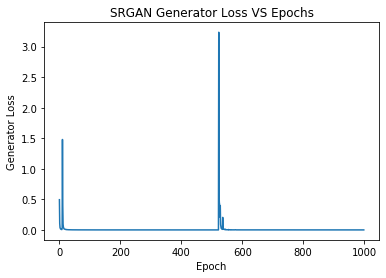

In [0]:
epoch_array=[i for i in range(epochs)]
plot = plt.plot(epoch_array , dis_loss)
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.title("SRGAN Generator Loss VS Epochs")
plt.savefig(os.path.join(path , 'SRGAN_Gen_Loss_Epoch.jpg'))
plt.show()

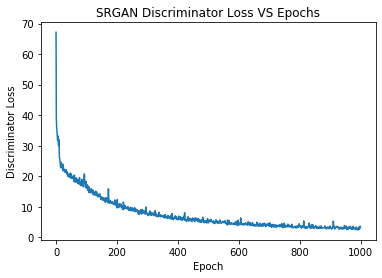

In [0]:
plot = plt.plot(epoch_array , gen_loss)
plt.xlabel('Epoch')
plt.ylabel('Discriminator Loss')
plt.title("SRGAN Discriminator Loss VS Epochs")
plt.savefig(os.path.join(path , 'SRGAN_Dis_Loss_Epoch.jpg'))
plt.show()

In [0]:
testImage=cv2.imread(os.path.join(path , 'Test.jpg'))

In [0]:
test_lr , no_images= splitImg(testImage,(100,100))

AttributeError: ignored

In [0]:
generated=[]

for img in test_lr:
  batch_lr=np.array([img])/255

  generated_image = generator.predict_on_batch(batch_lr)
  generated.append(generated_image[0])
generated=np.array(generated)

stiched_generated=stichImages(generated,(2000,2000))
stiched_generated = 255 *stiched_generated # Now scale by 255
stiched_generated = stiched_generated.astype(np.uint8)

imsave(os.path.join(path,'Test_FullImage.jpg'),stiched_generated)

NameError: ignored